In [73]:
import csv
import time 
import datetime
from statistics import mean, median, stdev
from dateutil import parser
import numpy as np
import random
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import dgl
import dgl.function as fn

from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GAE, VGAE, Node2Vec
from torch_geometric.utils import train_test_split_edges, remove_isolated_nodes, to_dense_adj
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [74]:
class Node():
    def __init__(self, addr, name, acc_type, contract_type, entity, label, tags=[]):
        self.addr = addr
        self.name = name
        self.acc_type = acc_type
        self.contract_type = contract_type
        self.entity = entity
        self.label = label
        self.tags = tags      
        self.txs_in = []
        self.txs_out = []
        
    def add_tx_in(self, tx):
        self.txs_in.append(tx)
        
    def add_tx_out(self, tx):
        self.txs_out.append(tx)
        
    def one_hot_feat_vec(self):
        vec = [0] * 8
        type_indexes = {'Wallet': 0, 'Smart Contract': 1}
        
        if self.acc_type != '':   
            vec[type_indexes[self.acc_type]] = 1
        
        if self.contract_type == 'Token':
            vec[2] = 1
            
        if self.entity:
            entity_indexes = {'Exchange': 3, 'Dex': 4, 'ICO Wallets': 5, 'Mining': 6, 'DeFi': 7}
            vec[entity_indexes[self.entity]] = 1
        
        return vec 
            
    def feature_vector(self, func):
        return func(self)

        
#     def one_hot_label(self, classes, label_switch=False):
#         label_vec = [0] * len(classes)
#         for index, acc in enumerate(classes):
#             kw = self.label if label_switch else self.acc_type
#             if acc == kw:
#                 label_vec[index] = 1
#                 break
#         return label_vec
        
    def __str__(self):
        return f"{self.acc_type} {self.addr}: {len(self.txs_in)} in, {len(self.txs_out)} out"

    
class Tx():
    
    def __init__(self, hsh, timestamp, tx_type, sender, receiver, contract, value, gasUsed, gasPrice, isError):
        self.hsh = hsh
        self.timestamp = timestamp
        self.tx_type = tx_type
        self.sender = sender
        self.receiver = receiver
        self.value = value
        self.contract = contract
        self.gasUsed = gasUsed
        self.gasPrice = gasPrice
        self.isError = isError
        
    def all_edge_vec(self):
        vec = [0] * 9
        
        type_indexes = {'Transfer': 0, 'Contract Invocation': 1, 'Contract Creation': 2, 'Internal': 3, 'Token': 4}
        vec[type_indexes[self.tx_type]] = 1
        
        vec[5] = float(self.value)
        vec[6] = float(self.gasUsed)
        vec[7] = float(self.gasPrice)
        vec[7] = float(self.isError)
        
        return vec
        
    def edge_vector(self, func):
        return func(self)
        
        
    def __str__(self):
        return f"{self.tx_type}: {self.value} from {self.sender} to {self.receiver}"
    
    def __eq__(self, other):
        return  (self.__class__ == other.__class__ and
                self.hsh == other.hsh and
                self.tx_type == other.tx_type and
                self.sender == other.sender and
                self.receiver == other.receiver and
                self.value == other.value)
                
    def __hash__(self):
        return hash(('hash', self.hsh, 'type', self.tx_type, self.sender, self.receiver, self.value))

In [75]:
def import_transactions(filename):
    transactions = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:

            if line_count == 0:
                line_count +=1
                continue
            else:
                transactions.append(row)
      
    return transactions

def import_exchanges(filename):
    exchanges = {}
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            exchanges[row[0]] = ''
            
    return exchanges

def import_labelled_addresses(filename):
    addresses = {}
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            addresses[row[0]] = [row[5], row[1], row[2], row[4]]
            
    return addresses

#Fetch reference nodes
def import_reference_nodes(filename):
    reference_nodes = {}
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter = ',')
        line_count = 0

        for row in csv_reader:

            if line_count == 0:
                line_count += 1 
                continue
            else:
                addr, name, acc_type, contract_type, entity, label, tags = parse_node_row(row)
                reference_nodes[row[0]] = Node(addr, name, acc_type, contract_type, entity, label, tags)
                
    return reference_nodes

In [76]:
def parse_node_row(row):
    return row[0], row[1], row[2], row[3], row[4], row[5], [x for x in row[6:] if x]

def parse_external_tx(row):
    code = row[14]
    gasUsed, gasPrice, isError =  int(row[16]), float(row[11]), row[12]
    gasPrice /= 1.0E+09
    
    if code == '0x' or int(code, 0) == 0:
        tx_type = 'Transfer'     
    else:
        tx_type = 'Contract Invocation'
    
    sender, receiver, contract = row[7], row[8], row[15]
    if receiver == '':
        tx_type = 'Contract Creation'
        receiver = row[15]

    value = float(row[9])
    value /= 1.0E+018
    d = datetime.datetime.fromtimestamp(int(row[2]))
    tx = Tx(row[3], d, tx_type, sender, receiver, contract, value, gasUsed, gasPrice, isError)
    return tx
def parse_internal_tx(row):
    d = datetime.datetime.fromtimestamp(int(row[2]))
    gasUsed, gasPrice, isError =  int(row[11]), float(row[10]), row[13]
    gasPrice /= 1.0E+09
    
    tx_type = 'Internal' 
    sender, receiver, contract = row[4], row[5], row[7]
    
    if receiver == '':
        receiver = contract
    
    value = float(row[6])
    value /= 1.0E+018
    
    tx = Tx(row[3], d, tx_type, sender, receiver, contract, value, gasUsed, gasPrice, isError) 
    return tx
    
def parse_token_tx(row):
    d = datetime.datetime.fromtimestamp(int(row[2]))
    gasUsed, gasPrice, isError =  int(row[15]), float(row[14]), 0
    gasPrice /= 1.0E+09
    
    tx_type = 'Token'
    sender, receiver, contract = row[6], row[8], row[7]
#     value = row[9]
    value = 1.0E+018
    value /= 1.0E+018
    
    tx = Tx(row[3], d, tx_type, sender, receiver, contract, value, gasUsed, gasPrice, isError)
    return tx

def parse_tx_row(row):  
    if row[0] == 'txlist':
        return parse_external_tx(row)
    elif row[0] == 'txlistinternal':
        return parse_internal_tx(row)
    elif row[0] == 'tokentx':
        return parse_token_tx(row)

In [77]:
def gen_tx_table(tx_list):
    transactions_table = {}
    for row in tx_list:
        tx = parse_tx_row(row)

        if tx.hsh in transactions_table.keys():
            transactions_table[tx.hsh].add(tx)
        else:
            s = set()
            s.add(tx)
            transactions_table[tx.hsh] = s

    return transactions_table

def tx_cleanup(txs):
    senders = set()
    for tx in txs:
        if tx.tx_type == 'Transfer':
            senders.add(tx.sender)

    for tx in txs:
        if tx.tx_type == 'Contract Invocation' and tx.receiver in senders:
            tx.tx_type = 'Transfer'
            
    return txs

def process_transactions(tx_list):
    transactions_table = gen_tx_table(tx_list)
    
    uniq_txs = list(transactions_table.values())
    uniq_txs = [list(x) for x in uniq_txs]
    return list(itertools.chain.from_iterable(uniq_txs))

def sort_by_date(tx_list):
    tx_list.sort(key= lambda x: x.timestamp)

def segment_transactions(tx_list, start, end):  
    sub_list = []
    
    for tx in tx_list:
        if tx.timestamp > start and tx.timestamp < end:
            sub_list.append(tx)
            
    return sub_list

def tx_stats(transactions):
    types= {
        'Transfer': 0,
        'Contract Creation': 0,
        'Contract Invocation': 0,
        'Internal': 0,
        'Token': 0
    }
    for tx in transactions:
        types[tx.tx_type] +=1

    print(types)

In [78]:
def assign_sender(tx_type):
    if tx_type in ['Transfer', 'Contract Invocation', 'Contract Creation']:
        return 'Wallet'
    elif tx_type in ['Internal']:
        return 'Smart Contract'
    else:
        return ''
    
def assign_receiver(tx_type):
    if tx_type in ['Transfer']:
        return 'Wallet'
    elif tx_type in ['Contract Invocation', 'Contract Creation']:
        return 'Smart Contract'
    else:
        return ''
    
def accounts_stats(node_dict):
    acc_dist = {}
    
    for addr, node in node_dict.items():
        kw = node.label if label_switch else node.typ
        if kw in acc_dist.keys():
            acc_dist[kw] += 1
        else:
            acc_dist[kw] = 0
            
    print(acc_dist)
    classes = sorted(list(acc_dist.keys()))
    if 'Wallet' in classes:
        classes.reverse()
    return acc_dist, classes

In [79]:
def make_nodes(transactions, reference_nodes, just_external=False):
    nodes = {}
    contracts = set()
    
    for tx in transactions:
        if just_external and tx.tx_type in ['Internal', 'Token']:
            continue
        
        sender, receiver = tx.sender, tx.receiver
        sender_type, receiver_type = assign_sender(tx.tx_type), assign_receiver(tx.tx_type)
                    
        if sender in nodes.keys():
            nodes[sender].add_tx_out(tx)
        else:
            if sender in reference_nodes.keys():
                nodes[sender] = reference_nodes[sender]
                nodes[sender].add_tx_out(tx)
            else:
                n = Node(sender, '', sender_type, '', '', '')
                n.add_tx_out(tx)
                nodes[sender] = n
                 
        if receiver in nodes.keys():
            nodes[receiver].add_tx_in(tx)
        else:
            if receiver in reference_nodes.keys():
                nodes[receiver] = reference_nodes[receiver]
                nodes[receiver].add_tx_in(tx)
            else:
                n = Node(receiver, '', receiver_type, '', '', '')
                n.add_tx_in(tx)
                nodes[receiver] = n
            
        if tx.contract != '':
            contracts.add(tx.contract)
            
    nodes.pop('', None) #empty node
    return nodes,contracts

def label_contracts(nodes, contracts):
    for addr in nodes.keys():
        if nodes[addr].acc_type == '' and addr in contracts:
            nodes[addr].acc_type = 'Smart Contract'

In [80]:
def nodes_stats(node_dict, category):
    acc_dist = {}
    
    for addr, node in node_dict.items():
        kw = vars(node)[category]
        if kw in acc_dist.keys():
            acc_dist[kw] += 1
        else:
            acc_dist[kw] = 0
            
    print(acc_dist)
    classes = sorted(list(acc_dist.keys()))
    classes.remove('')
    return acc_dist, classes

In [81]:
def assign_node_ids(nodes):
    keys = list(nodes.keys())
    random.shuffle(keys)
    for i, addr in enumerate(keys):
        nodes[addr].node_id = i

In [82]:
def normalize(vec, mins = [], maxs = []):
    if len(mins) == 0: 
        mins = vec.min(axis=0)
        maxs = vec.max(axis=0)
    
    return (vec - mins) / (maxs - mins)

def normalized(vec):
    norm =  np.linalg.norm(vec)
    n = vec / norm
    return n

def neg_normalize(vec):
    mins = vec.min(axis=0)
    maxs = vec.max(axis=0)
    return (vec - mins) / ((maxs - mins)/2)

def log_normalize(vec):
    return np.where(vec > 0, np.log(vec), 0)

In [83]:
from dateutil.relativedelta import *
def split_txs(txs, splitter):
    return splitter(txs)

def split_by_day(txs):
    
    txs_by_day = {}
    
    for tx in txs:
        date_str = str(tx.timestamp.month) + '/' + str(tx.timestamp.day)
        
        if date_str in txs_by_day.keys():
            txs_by_day[date_str].append(tx)
        else:
            txs_by_day[date_str] = [tx]
        
    return txs_by_day

def split_by_week(txs):
    txs.sort(key=lambda x:x.timestamp)
    first_tx = txs[0]
    first_d = first_tx.timestamp
    week_ahead = first_d + datetime.timedelta(days=+3)
    date_str = str(first_tx.timestamp.month) + '/' + str(first_tx.timestamp.day)
    
    txs_by_week = {}
    txs_by_week[date_str] = []
    
    for tx in txs:
        
        if tx.timestamp < week_ahead:
            txs_by_week[date_str].append(tx)
        else:
            date_str = str(tx.timestamp.month) + '/' + str(tx.timestamp.day)
            txs_by_week[date_str] = [tx]
            week_ahead = week_ahead + datetime.timedelta(days=+3)
            
    return txs_by_week
    
  

In [84]:
def ordered_address_list(nodes_dict):
    addresses = np.zeros((len(nodes_dict.keys())), dtype=object)
    
    for addr, node in nodes_dict.items():
        addresses[node.node_id] = addr
        
    return addresses

In [85]:
def transactions_to_edges(txs, nodes):
    l = len(txs)
    u = torch.zeros((l), dtype=torch.long)
    v = torch.zeros((l), dtype=torch.long)
    id_mask = np.array([])
    
    sub_nodes = {}
    count = 0
    
    for i, tx in enumerate(txs):
        
        if tx.sender not in sub_nodes.keys():
            sub_nodes[tx.sender] = count
            id_mask = np.append(id_mask, nodes[tx.sender].node_id)
            count += 1
            
        if tx.receiver not in sub_nodes.keys():
            sub_nodes[tx.receiver] = count
            id_mask = np.append(id_mask, nodes[tx.receiver].node_id)
            count += 1
            
        u[i] = sub_nodes[tx.sender]
        v[i] = sub_nodes[tx.receiver]
        
        
    return u, v, id_mask
    
    
    

In [86]:
def vec_lims(vec_list, vec_func):
    demo = vec_list[0]
    new_vec_len = len(vec_func(demo))
    list_length = len(vec_list)
    conv_vecs = np.zeros((list_length, new_vec_len))
    
    for i, vec in enumerate(vec_list):
        conv_vecs[i] = vec_func(vec)
        
    mins = conv_vecs.min(axis=0)
    maxs = conv_vecs.max(axis=0)
    
    return mins, maxs

def train_test_mask(length):

    train_mask = np.empty((length), bool)

    mask_border = int(length // 1.25) #80% train, 20% test

    for i in range(length):
        train_mask[i] = True if i < mask_border else False

    test_mask = np.invert(train_mask) 
    
    return train_mask, test_mask

In [87]:
def node_features(nodes, feature_func):
    demo = next(iter(nodes.values()))
    feat_length = len(feature_func(demo))
    feats = torch.zeros((len(nodes), feat_length))
    
    for addr, node in nodes.items():
        feats[node.node_id] = torch.FloatTensor(feature_func(node))
            
    return feats

def edge_feats(txs, edge_func):
    demo = txs[0]
    vec_len = len(edge_func(demo))
    edge_feats = torch.zeros((len(txs), vec_len))

    for i, tx in enumerate(txs): 
        edge_feats[i] = torch.FloatTensor(edge_func(tx))
            

    return edge_feats

In [88]:
def txs_to_pyg(u, v, e, feats):
    
    edge_index = torch.stack((u.t(), v.t()), dim=0)
    edge_index = edge_index.squeeze()
    
    u = torch.cat((u, v))
    v = torch.cat((v, u))
    e = torch.cat((e,e))
    
    g = Data(x=feats, edge_index=edge_index, edge_attr=e)
    
    return g
    
def sequence_of_pyg_graphs(split_transactions, nodes, node_feat_func, edge_func):
    node_feats = node_features(nodes, node_feat_func) 
    masks = {}
    graphs = {}
    
    for incr, txs in split_transactions.items():
        u, v, id_mask = transactions_to_edges(txs, nodes)
        e = edge_feats(txs, edge_func)
#         e = normalize(e, edge_mins, edge_maxs)
        graphs[incr] = txs_to_pyg(u, v, e, node_feats[id_mask])
        masks[incr] = id_mask
    return graphs, masks

In [89]:
#GAE
class Encoder(torch.nn.Module):
    def __init__(self, model_type, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.model_type = model_type
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=False)
        if self.model_type in ['GAE']:
            self.conv2 = GCNConv(2 * out_channels, out_channels, cached=False)
        elif self.model_type in ['VGAE']:
            self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=False)
            self.conv_logstd = GCNConv(2 * out_channels, out_channels,
                                       cached=False)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        if self.model_type in ['GAE']:
            return self.conv2(x, edge_index)
        elif self.model_type in ['VGAE']:
            return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
        
def setup_ae_model(model_type, in_features, embed_dims):
    model_options = {'GAE': GAE, 'VGAE': VGAE}
    dev = torch.device('cuda:0')
    model = model_options[model_type](Encoder(model_type, in_features, embed_dims)).to(dev)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    return model, optimizer

def graph_split(g_list): 
    for g in g_list.values():
        g = train_test_split_edges(g)
    
def data_to_device(g, dev):
    x, train_pos_edge_index = g.x.to(dev), g.train_pos_edge_index.to(dev)
    return x, train_pos_edge_index

def train_gae(model, model_type, optimizer, graph_list, dev):
    model.train()
    optimizer.zero_grad()
    

    keys = list(graph_list.keys())
    random.shuffle(keys)
    
    for key in keys:
        graph = graph_list[key]
        x, train_pos_edge_index = data_to_device(graph, dev)
        z = model.encode(x, train_pos_edge_index)
        loss = model.recon_loss(z, train_pos_edge_index)
        if model_type in ['VGAE']:
            loss = loss + (1 / data.num_nodes) * model.kl_loss()
            
    loss.backward()
    optimizer.step()
    
def test_gae(model, graph_list, dev):
    dev = torch.device('cuda:0')
    AUC = 0
    AP = 0
    model.eval()
    with torch.no_grad():
        for graph in graph_list.values():
            z = model.encode(graph.x.to(dev), graph.train_pos_edge_index.to(dev))
            auc, ap = model.test(z, graph.test_pos_edge_index, graph.test_neg_edge_index)
            AUC += auc
            AP += ap
           
    N = len(graph_list)
    return AUC/N, AP/N

def train_gae_epochs(graphs, epochs):
    t = 'GAE'
    model, optimizer = setup_ae_model(t, 8, 16)
    graph_split(graphs)
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        train_gae(model, 'GAE', optimizer, graphs, 'cuda:0')
        auc, ap = test_gae(model, graphs, 'cuda')
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
        
    return model

In [90]:
##CONTROL THE PROGRAMME HERE 
dev = torch.device('cuda:0')
edge_func = Tx.all_edge_vec
node_feat_func = Node.one_hot_feat_vec

In [91]:
#Process transactions
exchanges = import_exchanges('./exchanges.csv')
reference_nodes = import_reference_nodes('./addresses/final.csv')

transactions = import_transactions("./transactions/2019-4-11-to-2019-7-11/2019-4-11-to-2019-7-11-txs-byN.csv")
transactions = process_transactions(transactions)
transactions = tx_cleanup(transactions)
sort_by_date(transactions)
tx_stats(transactions)

{'Transfer': 234628, 'Contract Creation': 2715, 'Contract Invocation': 276622, 'Internal': 92181, 'Token': 436874}


In [92]:
#Nodes
nodes, contracts = make_nodes(transactions, reference_nodes, False)
label_contracts(nodes, contracts)
assign_node_ids(nodes)

In [93]:
#Stats
nodes_stats(nodes, 'entity')
nodes_stats(nodes, 'acc_type')
nodes_stats(nodes, 'contract_type')
nodes_stats(nodes, 'label')

{'': 496600, 'Exchange': 141, 'Mining': 21, 'Dex': 21, 'DeFi': 30, 'ICO Wallets': 59}
{'': 315571, 'Wallet': 156167, 'Smart Contract': 25137}
{'': 496384, 'Token': 492}
{'': 495407, 'Legit': 903, 'Dodgy': 565}


({'': 495407, 'Legit': 903, 'Dodgy': 565}, ['Dodgy', 'Legit'])

In [94]:
#Split up transactions
txs_dict = split_txs(transactions, split_by_day)

In [95]:
#For easy access to address keys using node_id
addresses = ordered_address_list(nodes)

In [96]:
edge_mins, edge_maxs = vec_lims(transactions, edge_func) # for universal normalizing (consistent between graphs)

In [97]:
def autoencoder_embedding(graph):
    return gae_model.encode(graph.x.to(dev), graph.edge_index.to(dev))

def agg_transactions(edge_index, edge_attrs):
    e_len = len(edge_attrs[0])
    sub_nodes = {}
    
    for i in range(len(edge_index[0])):
        pad = torch.zeros((e_len))
        u = edge_index[0][i].item()
        v = edge_index[1][i].item()
        e = edge_attrs[i]
        
        in_vec = torch.cat((e, pad), 0)
        out_vec = torch.cat((pad, e), 0)
        
        if u in sub_nodes.keys():
            sub_nodes[u] += out_vec
        else:
            sub_nodes[u] = out_vec
            
        if v in sub_nodes.keys():
            sub_nodes[v] += in_vec
        else:
            sub_nodes[v] = in_vec
            
    return sub_nodes

def avg_value_stats(sub_nodes, e_len):
    for i in sub_nodes.keys():
        num_in = sum(sub_nodes[i][0:5]).item()
        num_out = sum(sub_nodes[i][e_len:e_len + 5]).item()
        
        if num_in > 0:
            sub_nodes[i][5:e_len - 1] /= num_in
        if num_out > 0:
            sub_nodes[i][5 + e_len:2*e_len - 1] /= num_out
    
    return sub_nodes
    

def graph_to_edge_stats_embed(graph):
    e_len = len(graph.edge_attr[0])
    x_len = len(graph.x[0])
    
    embeddings = torch.zeros((len(graph.x), e_len*2 + x_len))
    
    sub_nodes = agg_transactions(graph.edge_index, graph.edge_attr)
    sub_nodes = avg_value_stats(sub_nodes, e_len)
    
    embeddings[:, 0:x_len] = graph.x
    
    for i, vec in sub_nodes.items():
        embeddings[i, x_len:] = vec
    
    return embeddings

In [98]:
def build_embedding_tensor(graphs, masks, embedder, embed_len):
    SEQ_TENSOR = torch.zeros((len(graphs), len(nodes), embed_len))
    for i, (date, graph) in enumerate(graphs.items()):
        embeddings = embedder(graph)
        SEQ_TENSOR[i, masks[date], :] = embeddings.cpu()
    return SEQ_TENSOR

In [99]:
graphs, masks = sequence_of_pyg_graphs(txs_dict, nodes, node_feat_func, edge_func)
embedding_engine = autoencoder_embedding
embed_len = 16

In [100]:
graphs

{'4/11': Data(edge_attr=[142694, 9], edge_index=[2, 71347], x=[28887, 8]),
 '4/12': Data(edge_attr=[107226, 9], edge_index=[2, 53613], x=[28204, 8]),
 '4/13': Data(edge_attr=[67998, 9], edge_index=[2, 33999], x=[21864, 8]),
 '4/14': Data(edge_attr=[50456, 9], edge_index=[2, 25228], x=[19835, 8]),
 '4/15': Data(edge_attr=[41606, 9], edge_index=[2, 20803], x=[16574, 8]),
 '4/16': Data(edge_attr=[85076, 9], edge_index=[2, 42538], x=[27557, 8]),
 '4/17': Data(edge_attr=[37840, 9], edge_index=[2, 18920], x=[14075, 8]),
 '4/18': Data(edge_attr=[38660, 9], edge_index=[2, 19330], x=[14983, 8]),
 '4/19': Data(edge_attr=[25912, 9], edge_index=[2, 12956], x=[9401, 8]),
 '4/20': Data(edge_attr=[30380, 9], edge_index=[2, 15190], x=[10555, 8]),
 '4/21': Data(edge_attr=[33030, 9], edge_index=[2, 16515], x=[11346, 8]),
 '4/22': Data(edge_attr=[38876, 9], edge_index=[2, 19438], x=[11161, 8]),
 '4/23': Data(edge_attr=[66350, 9], edge_index=[2, 33175], x=[19857, 8]),
 '4/24': Data(edge_attr=[48526, 9], e

In [101]:
gae_model = train_gae_epochs(graphs, 150)
graphs, _ = sequence_of_pyg_graphs(txs_dict, nodes, node_feat_func, edge_func)

Epoch 0
Epoch: 000, AUC: 0.8026, AP: 0.8185
Epoch 1
Epoch: 001, AUC: 0.8285, AP: 0.8404
Epoch 2
Epoch: 002, AUC: 0.8602, AP: 0.8700
Epoch 3
Epoch: 003, AUC: 0.8988, AP: 0.9050
Epoch 4
Epoch: 004, AUC: 0.9230, AP: 0.9267
Epoch 5
Epoch: 005, AUC: 0.9461, AP: 0.9488
Epoch 6
Epoch: 006, AUC: 0.9611, AP: 0.9626
Epoch 7
Epoch: 007, AUC: 0.9726, AP: 0.9729
Epoch 8
Epoch: 008, AUC: 0.9805, AP: 0.9806
Epoch 9
Epoch: 009, AUC: 0.9852, AP: 0.9851
Epoch 10
Epoch: 010, AUC: 0.9881, AP: 0.9879
Epoch 11
Epoch: 011, AUC: 0.9886, AP: 0.9886
Epoch 12
Epoch: 012, AUC: 0.9880, AP: 0.9883
Epoch 13
Epoch: 013, AUC: 0.9869, AP: 0.9875
Epoch 14
Epoch: 014, AUC: 0.9850, AP: 0.9861
Epoch 15
Epoch: 015, AUC: 0.9833, AP: 0.9849
Epoch 16
Epoch: 016, AUC: 0.9823, AP: 0.9846
Epoch 17
Epoch: 017, AUC: 0.9813, AP: 0.9839
Epoch 18
Epoch: 018, AUC: 0.9806, AP: 0.9836
Epoch 19
Epoch: 019, AUC: 0.9796, AP: 0.9829
Epoch 20
Epoch: 020, AUC: 0.9788, AP: 0.9824
Epoch 21
Epoch: 021, AUC: 0.9771, AP: 0.9812
Epoch 22
Epoch: 022,

In [102]:
EMBEDDINGS_TENSOR = build_embedding_tensor(graphs, masks, embedding_engine, embed_len)

In [103]:
t2 = build_embedding_tensor(graphs, masks, graph_to_edge_stats_embed, 26)

In [135]:
a = []
b = []
for node in nodes.values():
    if node.contract_type == 'Token':      
        a.append(node.node_id)
#     elif node.entity == 'Dex':
#         b.append(node.node_id)
        
    if len(a) == 20:
        break
        
a, b = a[0:], a[10:]

In [136]:
d = datetime.datetime(2019, 4, 11)
dates = []
for i in range(91):
    dates.append(d)
    d = d + datetime.timedelta(days=+1)

In [137]:
from sklearn.preprocessing import normalize as nz

def normalized(arr):
    return nz(arr, axis=0)

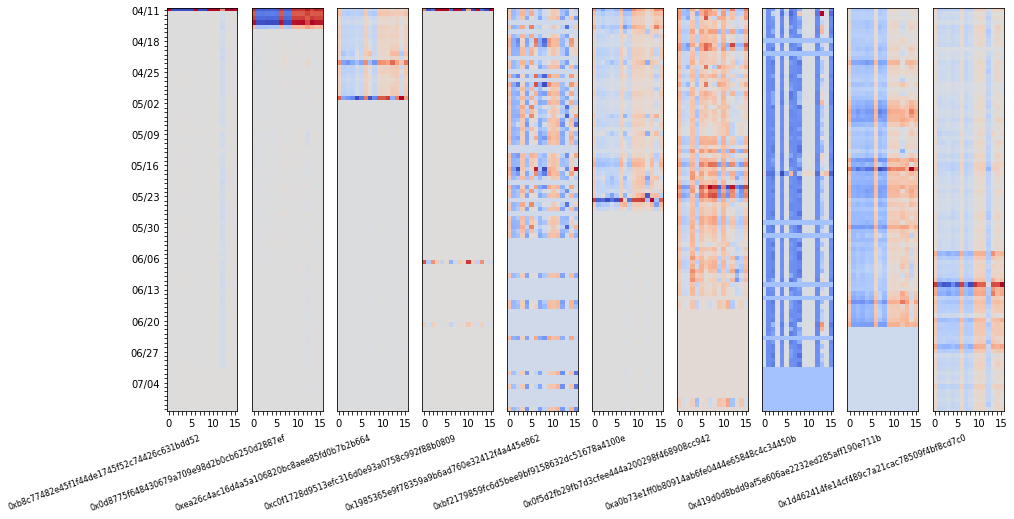

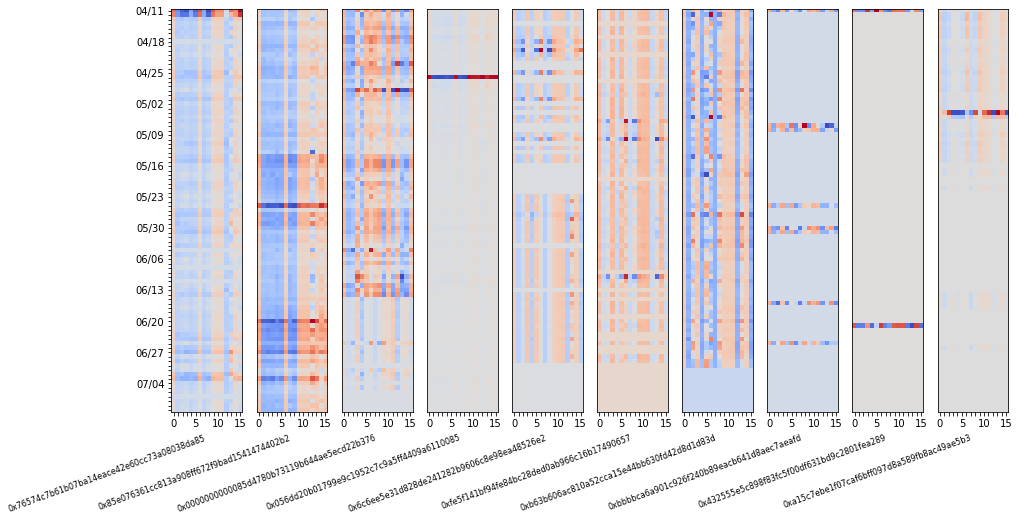

In [138]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d')


fig, axs = plt.subplots(1,10, figsize=(15,20))

# 

for i in range(10):
    v = EMBEDDINGS_TENSOR[:, a[i], :].detach().numpy()
    v = normalized(v)
    
    axs[i].imshow(v, cmap='coolwarm')
    feat_length = v.shape[1]
    axs[i].set_xticks(np.arange(feat_length))
    axs[i].set_xlabel(f"{nodes[addresses[a[i]]].addr}", fontsize=8, rotation=20, ha='right')
    for i, l in enumerate(axs[i].xaxis.get_ticklabels()[:]):
        if i % 5 != 0:  
            l.set_visible(False)
            
    
axs[0].set_yticks([i for i, x in enumerate(dates)])
axs[0].set_yticklabels([x.strftime("%m/%d") for x in dates])
for i, l in enumerate(axs[0].yaxis.get_ticklabels()[:]):
        if i % 7 != 0:  
            l.set_visible(False)
            
for i in range(1, 10):
    axs[i].set_yticks([])
    

fig2, axs2 = plt.subplots(1,10, figsize=(15,20))
for i in range(10):
    v = EMBEDDINGS_TENSOR[:, b[i], :].detach().numpy()
    v = normalized(v)
    axs2[i].imshow(v, cmap='coolwarm')
    feat_length = v.shape[1]
    axs2[i].set_xticks(np.arange(feat_length))
    axs2[i].set_xlabel(f"{nodes[addresses[b[i]]].addr}", fontsize=8, rotation=20, ha='right')
    for i, l in enumerate(axs2[i].xaxis.get_ticklabels()[:]):
        if i % 5 != 0:  
            l.set_visible(False)
            
axs2[0].set_yticks([i for i, x in enumerate(dates)])
axs2[0].set_yticklabels([x.strftime("%m/%d") for x in dates])
for i, l in enumerate(axs2[0].yaxis.get_ticklabels()[:]):
        if i % 7 != 0:  
            l.set_visible(False)
            
for i in range(1, 10):
    axs2[i].set_yticks([])

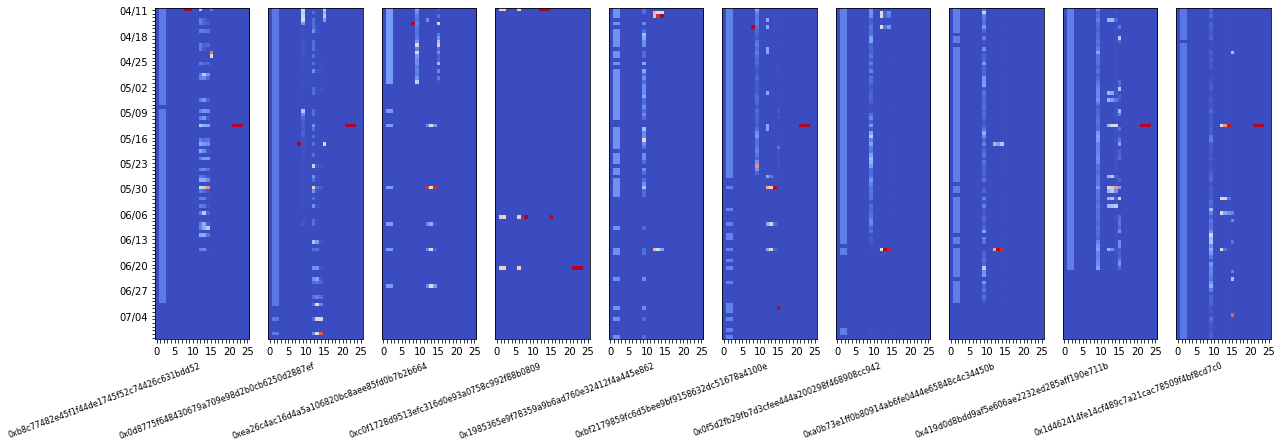

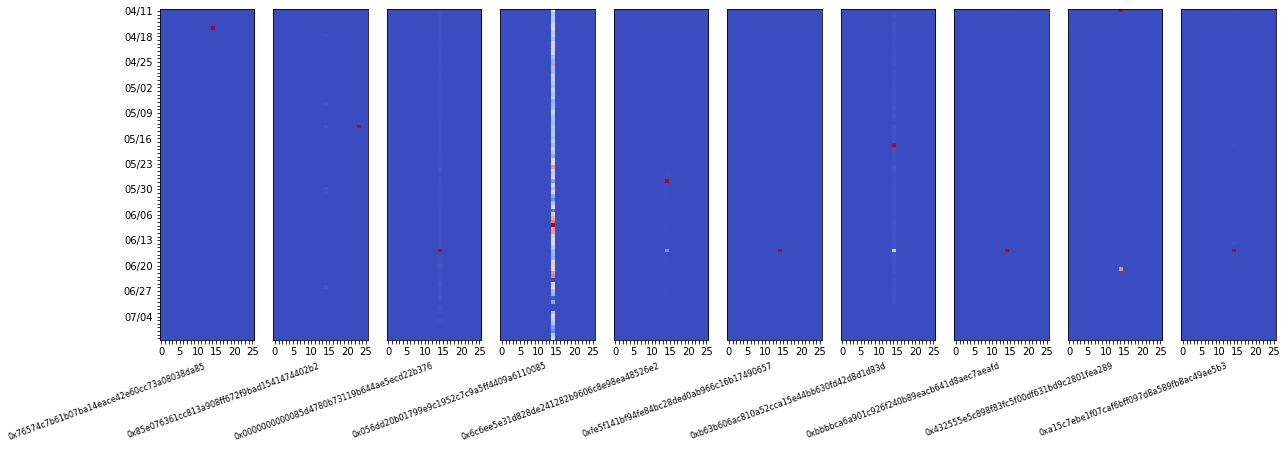

In [139]:
fig3, axs3 = plt.subplots(1,10, figsize=(20,20))

for i in range(10):
    v = t2[:, a[i], :].detach().numpy()
    v = normalized(v)
    axs3[i].imshow(v, cmap='coolwarm')
    feat_length = v.shape[1]
    axs3[i].set_xticks(np.arange(feat_length))
    axs3[i].set_xlabel(f"{nodes[addresses[a[i]]].addr}", fontsize=8, rotation=20, ha='right')
    for i, l in enumerate(axs3[i].xaxis.get_ticklabels()[:]):
        if i % 5 != 0:  
            l.set_visible(False)
            
axs3[0].set_yticks([i for i, x in enumerate(dates)])
axs3[0].set_yticklabels([x.strftime("%m/%d") for x in dates])
for i, l in enumerate(axs3[0].yaxis.get_ticklabels()[:]):
        if i % 7 != 0:  
            l.set_visible(False)
            
for i in range(1, 10):
    axs3[i].set_yticks([])
 

fig3, axs4 = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
    v = t2[:, b[i], :].detach().numpy()
#     v = normalized(v)
    axs4[i].imshow(v, cmap='coolwarm')
    feat_length = v.shape[1]
    axs4[i].set_xticks(np.arange(feat_length))
    axs4[i].set_xlabel(f"{nodes[addresses[b[i]]].addr}", fontsize=8, rotation=20, ha='right')
    for i, l in enumerate(axs4[i].xaxis.get_ticklabels()[:]):
        if i % 5 != 0:  
            l.set_visible(False)
            
axs4[0].set_yticks([i for i, x in enumerate(dates)])
axs4[0].set_yticklabels([x.strftime("%m/%d") for x in dates])
for i, l in enumerate(axs4[0].yaxis.get_ticklabels()[:]):
        if i % 7 != 0:  
            l.set_visible(False)
            
for i in range(1, 10):
    axs4[i].set_yticks([])

In [38]:
t2.shape

torch.Size([91, 496878, 26])

In [39]:
def double_shuffle(vec1, vec2):
    assert len(vec1) == len(vec2)
    p = np.random.permutation(len(vec1))
    return vec1[p], vec2[p]

In [40]:
# a = []
# b = []
# for node in nodes.values():
#     if node.acc_type == 'Smart Contract':      
#         a.append(node.node_id)
#     elif node.acc_type == 'Wallet':
#         b.append(node.node_id)

# a = a[0:500]
# b = b[0:500]
# train_split = int(len(a) / 1.25)
# test_split = len(a) - train_split

In [41]:
a = []
b = []
for node in nodes.values():
    if node.label == 'Dodgy':      
        a.append(node.node_id)
    elif node.label == 'Legit':
        b.append(node.node_id)

# a = a[0:300]
b = b[0:len(a)]
train_split = int(len(a) / 1.25)
test_split = len(a) - train_split

In [ ]:
import torch.nn.functional as f
T = torch.cat((EMBEDDINGS_TENSOR, t2), dim=2)
f.normalize(T, p=1, dim=2)
window = 3
embed_len = T.shape[-1]
whole_window = T.shape[0]
num_nodes = len(a)
num_windows = (whole_window - window) + 1

In [ ]:
fraud_train = T[:, a[0:train_split], :]
fraud_test = T[:, a[train_split:], :]
other_train = T[:, b[0:train_split], :]
other_test = T[:, b[train_split:], :]

In [ ]:
f_seqs = torch.zeros([num_windows * train_split, window, embed_len], dtype=torch.float)
for i in range(train_split):
    for j in range(num_windows):
        f_seqs[i + j] = fraud_train[j:j+window, i, :]
        
o_seqs = torch.zeros([num_windows * train_split, window, embed_len], dtype=torch.float)
for i in range(train_split):
    for j in range(num_windows):
        o_seqs[i + j] = other_train[j:j+window, i, :]
        
f_seqs_test = torch.zeros([num_windows * test_split, window, embed_len], dtype=torch.float)
for i in range(test_split):
    for j in range(num_windows):
        f_seqs_test[i + j] = fraud_test[j:j+window, i, :]
        
o_seqs_test = torch.zeros([num_windows * test_split, window, embed_len], dtype=torch.float)
for i in range(test_split):
    for j in range(num_windows):
        o_seqs_test[i + j] = other_test[j:j+window, i, :]

In [ ]:
# f_seqs = torch.zeros([num_windows * train_split, window, embed_len], dtype=torch.float)
# for i, split in enumerate(torch.split(fraud_train, window)):
#     for j in range(split.shape[1]):
#         f_seqs[i+j] = split[:, j, :]
        
# o_seqs = torch.zeros([num_windows * train_split, window, embed_len], dtype=torch.float)
# for i, split in enumerate(torch.split(other_train, window)):
#     for j in range(split.shape[1]):
#         o_seqs[i+j] = split[:, j, :]
        
# f_seqs_test = torch.zeros([num_windows * test_split, window, embed_len], dtype=torch.float)
# for i, split in enumerate(torch.split(fraud_test, window)):
#     for j in range(split.shape[1]):
#         f_seqs_test[i+j] = split[:, j, :]
        
# o_seqs_test = torch.zeros([num_windows * test_split, window, embed_len], dtype=torch.float)
# for i, split in enumerate(torch.split(other_test, window)):
#     for j in range(split.shape[1]):
#         o_seqs_test[i+j] = split[:, j, :]

In [ ]:
f_labels = torch.ones((f_seqs.shape[0]))
o_labels = torch.zeros((o_seqs.shape[0]))
f_labels_test = torch.ones((f_seqs_test.shape[0]))
o_labels_test = torch.zeros((o_seqs_test.shape[0]))

In [ ]:
seqs_train = torch.cat((f_seqs, o_seqs))
labels_train = torch.cat((f_labels, o_labels))

seqs_test = torch.cat((f_seqs_test, o_seqs_test))
labels_test = torch.cat((f_labels_test, o_labels_test))

In [ ]:
f_seqs.shape

In [ ]:
for i, n  in enumerate(seqs_train):
    txs = 0
    for w in n:
        txs_in = sum(w[26:31])
        txs_out = sum(w[37:])
        txs += txs_in
        txs += txs_out
        
    if txs == 0: #i.e no transactions made for this window
        labels_train[i] = 0.5

In [ ]:
print(len(labels_train))
print(sum(labels_train))

In [ ]:
seqs_train, labels_train = double_shuffle(seqs_train, labels_train)
seqs_test, labels_test = double_shuffle(seqs_test, labels_test)

In [ ]:
#hyperparemeters
device = torch.device('cuda:0')
sequence_length = window
input_size = embed_len
hidden_size = 128
num_layers = 1
num_classes = 1
# batch_size = 100
epochs = 400
learning_rate = 0.1

In [ ]:
import torch.nn.init as weight_init

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        intermediate = int(input_size / 2)
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lin = nn.Linear(input_size, intermediate)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn = nn.RNN(intermediate, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        #Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        #Forward propagate LSTM
        
#         x = self.lin(x)
        out, _ = self.lstm(x, (h0, c0))
#         out, _ = self.rnn(x, h0)
        
        #decode the hidden stae of the last time step
        out = self.fc(out[:, -1, :])
        #sigmoid ??
        out = F.sigmoid(out)
        return out
    
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
for name, param in model.lstm.named_parameters():
    if 'bias' in name:
        nn.init.constant(param, 0.0)
    elif 'weight' in name:
        nn.init.xavier_normal(param)
    
#loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        

seqs_train = seqs_train.detach().to(device)
labels_train = labels_train.to(device)
    
#Train model
# total_step = seqs_train.shape[0]
model.train()
for epoch in range(epochs):
    #forward pass
    
    outputs = model(seqs_train)
#     loss = F.binary_cross_entropy(outputs, labels_train)
    loss = criterion(outputs, labels_train)

    #backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    seqs_train, labels_train = double_shuffle(seqs_train, labels_train)
    if epoch % 1 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss {loss.item()}")

In [ ]:
seqs_train.shape

In [ ]:
init.xavier_normal()

In [ ]:
for r in T[:, 0, :]:
    print(r)

In [ ]:
f_seqs.shape

In [ ]:
import torch.nn.functional as f
f .normalize(EMBEDDINGS_TENSOR, p=2, dim=2)